# Pricevolume Alpha

- Alpha only using price & volume data
- Long-only Alpha

In [67]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

from collections import Counter
from pprint import pprint as pp

In [2]:
import quantstats as qs

In [3]:
cwd = Path.cwd()
data_dir = cwd / "data"
fnguide_dir = data_dir / "fnguide"
kqdl_dir = data_dir / "kqdl"
navernews_dir = data_dir / "navernews" / "navernews"

## 1. Load Dataset

In [12]:
## 추출한 fnguide 데이터를 dataframe으로 전처리

def preprocess_dataguide_csv(fn_file_name, cols, skiprows=8, encoding="cp949"):
    fn_df = pd.read_csv(fnguide_dir / fn_file_name, encoding=encoding, skiprows=skiprows, thousands=",")
    fn_df = fn_df.melt(id_vars=cols, var_name="date", value_name="value")

    return fn_df

In [13]:
fn_file_names = [
    'dataguide_kse+kosdaq_20140101-20231215_stc_pricevolume.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_stc_mktcap.CSV',
]

In [14]:
## 날짜가 아닌 컬럼들

cols = ['Symbol', 'Symbol Name', 'Kind', 'Item', 'Item Name ', 'Frequency',]

In [15]:
pricevolume_df = preprocess_dataguide_csv(fn_file_names[0], cols)
mktcap_df = preprocess_dataguide_csv(fn_file_names[1], cols)

In [16]:
pricevolume_df['Item Name '].unique()

array(['수익률(%)', '수정주가(원)', '수정저가(원)', '수정고가(원)', '수정시가(원)', '거래량(주)',
       '거래대금(원)'], dtype=object)

In [17]:
mktcap_df['Item Name '].unique()

array(['시가총액 (티커-상장예정주식수 미포함)(백만원)'], dtype=object)

In [18]:
def get_panel_df(df, item_name):
    panel_df = df.loc[df['Item Name '] == item_name].copy()
    panel_df = panel_df.pivot(index='date', columns='Symbol', values='value')
    panel_df = panel_df.reset_index()
    
    return panel_df

In [19]:
def transform_panel(panel_df, remove_holidays=True, drop_sid_prefix=True):
    panel_df = panel_df.set_index('date', inplace=False)
    panel_df.sort_index(inplace=True)

    if drop_sid_prefix:
        panel_df.columns = [sid[1:] for sid in panel_df.columns]

    if remove_holidays:
        panel_df = panel_df.dropna(how='all', axis=0)
    
    return panel_df

In [20]:
return_2d = transform_panel(get_panel_df(pricevolume_df, '수익률(%)'))

open_2d = transform_panel(get_panel_df(pricevolume_df, '수정시가(원)'))
high_2d = transform_panel(get_panel_df(pricevolume_df, '수정고가(원)'))
low_2d = transform_panel(get_panel_df(pricevolume_df, '수정저가(원)'))
close_2d = transform_panel(get_panel_df(pricevolume_df, '수정주가(원)'))

tradingmoneyvolume_2d = transform_panel(get_panel_df(pricevolume_df, '거래대금(원)'))

mktcap_2d = transform_panel(get_panel_df(mktcap_df, '시가총액 (티커-상장예정주식수 미포함)(백만원)'))


## 3. Universe Filtering 

현실적인 포트폴리오 백테스팅을 위해 유동성 상위 2000 종목으로만 구성된 유니버스를 구성

이 때, 20일 평균 거래대금을 사용하여 일자별 변동을 줄임. (smooth univ 2000)

In [22]:
START_DATE = '2014-01-01'
END_DATE = '2022-05-31' # news dataset은 여기까지 있음. 

SUBUNIVERSE = 2000
UNIV_SMOOTHING_WINDOW = 20

In [23]:
liquidity_rank_2d = tradingmoneyvolume_2d.rank(axis=1, method='dense', ascending=False)
smooth_liquidity_rank_2d = liquidity_rank_2d.rolling(UNIV_SMOOTHING_WINDOW).mean()

univ2000_2d = liquidity_rank_2d <= SUBUNIVERSE
smooth_univ2000_2d = smooth_liquidity_rank_2d <= SUBUNIVERSE

In [24]:
# 모든 데이터셋에 smooth_univ2000 mask 적용

return_2d = return_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]

open_2d = open_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]
high_2d = high_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]
low_2d = low_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]
close_2d = close_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]

tradingmoneyvolume_2d = tradingmoneyvolume_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]

mktcap_2d = mktcap_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]


In [25]:
return_2d = return_2d * 0.01 # % -> decimal

In [26]:
return_2d.dropna(axis=1, how='all', inplace=True)

open_2d.dropna(axis=1, how='all', inplace=True)
high_2d.dropna(axis=1, how='all', inplace=True)
low_2d.dropna(axis=1, how='all', inplace=True)
close_2d.dropna(axis=1, how='all', inplace=True)

tradingmoneyvolume_2d.dropna(axis=1, how='all', inplace=True)

mktcap_2d.dropna(axis=1, how='all', inplace=True)

## 2. Make Alphas

- Idea 1: 상따 (상한가 따라잡기)
    - 상한가처럼 크게 오른 종목 long, 다음 거래일 short 
        - 크게 오른 의 기준은? 
            - hard threshold 쓸 것인지? (eg: 25%) vs 통계 기반 rule 사용
            - market cap에 따라 크게 오른의 기준이 다를 수 있다. 
                - 시총 높은 기업은 상한가를 찍기는 어려움.
                - 애초에 그런 기업은 상따 대상이 아니지 않을까?
            - daily return +가 아닌 당일 상승마감이 더 중요할 수 있음. 
                - 전일 close - 당일 close 증가율 대신
                - 당일 open - 당일 close 증가율 확인
        - D-0 vs D-1
            - D-0에서만 working하고 D-1에는 시그널 사라질 가능성이 높음... EDA 필요
        - 추가 필터가 필요하지 않을까? 
            - 정보 반영이 느린 작은 종목에서 잘 먹힐 가능성 있음. 
    - 참고: [매경컬럼 [필동정담] 상한가 따라잡기](https://www.mk.co.kr/news/columnists/10806171)

### 상한가 기준

- 통계기반 rule 사용
    - cross sectional에서 + 증가율 기록한 곳 중 상위 n%
    - 이 때의 "증가율"은 당일 open-close 증가율을 뜻함. 

In [69]:
openclose_return_2d = (close_2d - open_2d).div(open_2d) 

TOP = 0.10

positive_openclose_mask = openclose_return_2d > 0

# This is our base signal
top_openclose_2d = (openclose_return_2d * positive_openclose_mask).rank(axis=1, method='dense', ascending=False, pct=True) <= TOP


In [57]:
signal_d0returns = (top_openclose_2d * return_2d).stack()

In [59]:
signal_d0returns = signal_d0returns[signal_d0returns != 0]

<Axes: ylabel='Count'>

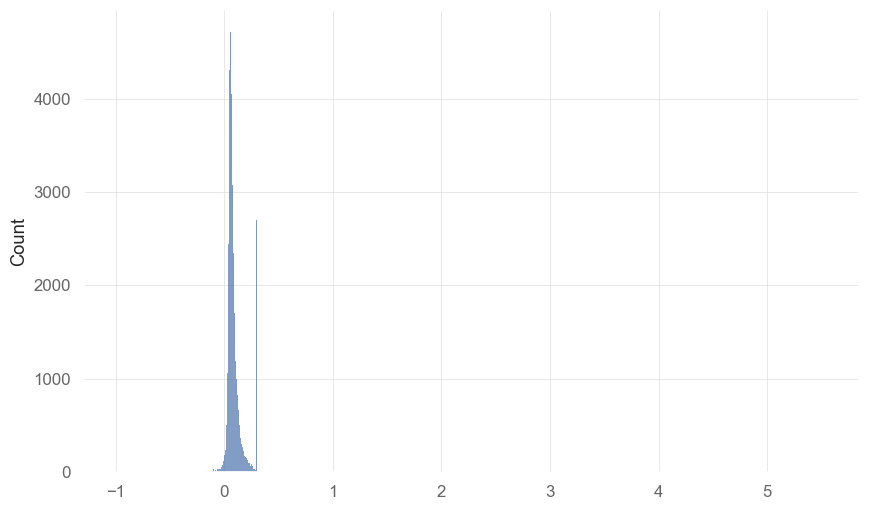

In [63]:
sns.histplot(data=signal_d0returns.values)

In [64]:
signal_d0returns.describe()

count    165122.000000
mean          0.087562
std           0.065398
min          -0.963700
25%           0.052600
50%           0.070600
75%           0.103100
max           5.521700
dtype: float64

매일매일 시그널 뜬 종목들은 얼마나 될까? 

<Axes: xlabel='date'>

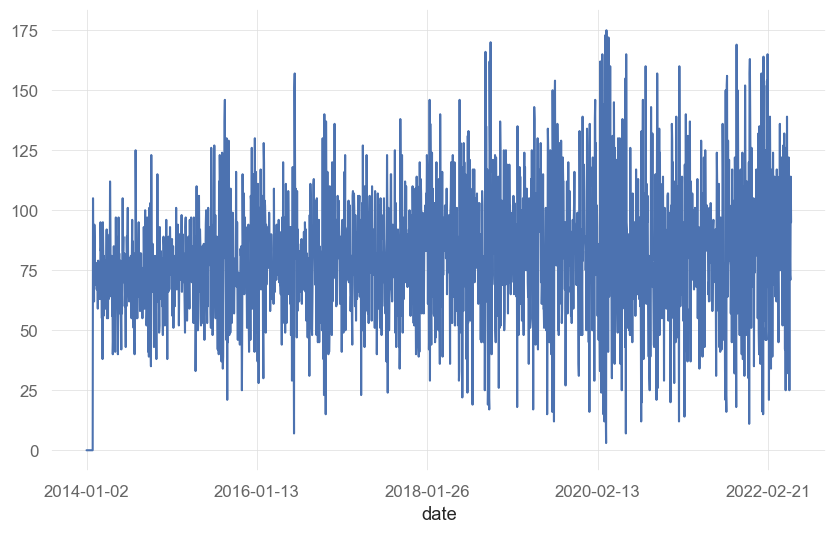

In [72]:
top_openclose_2d.sum(axis=1).plot()

In [73]:
top_openclose_2d.sum(axis=1).describe()

count    2069.000000
mean       80.098115
std        28.329874
min         0.000000
25%        63.000000
50%        79.000000
75%        96.000000
max       175.000000
dtype: float64

평균 80개의 적은 수의 종목만 들고가는 전략. 매우 적은 수의 종목만 보유해야 하는 날도 생김. 

상한가가 없어서 보유 못하는 날도 생김. 

In [68]:
Counter(signal_d0returns.values).most_common(5)

[(0.3, 759), (0.0526, 502), (0.0667, 442), (0.15, 419), (0.0556, 414)]

정상적으로 상한가 30%가 많이 나오는 것을 볼 수 있었다. 

## 3. Test Alphas

- 고의로 forward looking으로 backtesting하여 alpha에 시그널이 존재하는지 확인하고
    - signal weight
    - equal weight
- 1 day shift 하여 forward looking 없는 정상적인 backtesting 결과 확인

### Signal 확인

forward looking 의도적으로 허용

상한가 당일 close로 보유했다고 가정, 다음날 open에 전량 매도

#### equal weight

In [74]:
prevclose_2d = close_2d.shift(1)
prevclose_open_return_2d = (open_2d - prevclose_2d).div(prevclose_2d)

In [78]:
# fwdB = forward Bias

fwdB_equal_return_2d = top_openclose_2d * prevclose_open_return_2d.shift(-1)
fwdB_equal_returns = fwdB_equal_return_2d.mean(axis=1)

<Axes: xlabel='date'>

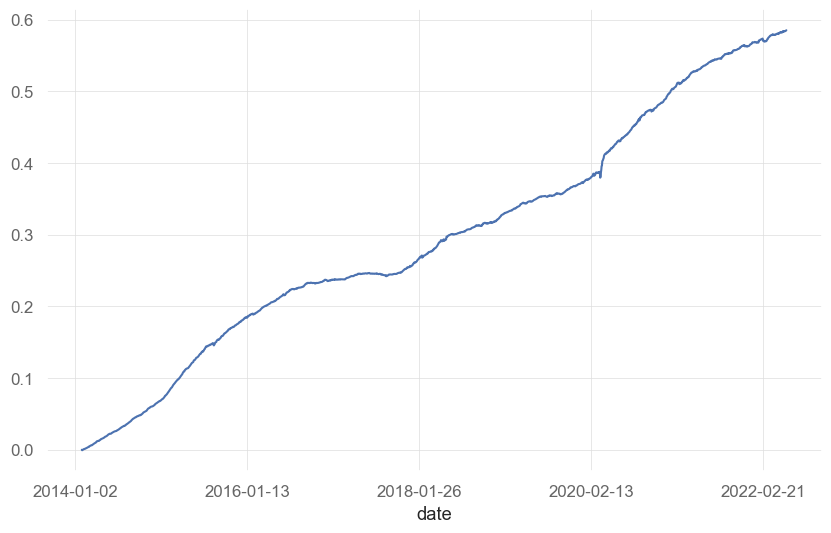

In [81]:
((1+fwdB_equal_returns).cumprod()-1).plot()

전형적인 forward looking 그래프 나옴.

#### signal weight

### backtesting

forward looking 차단

상한가 다음날 open에 보유한다고 가정, 당일 종가에 매도

#### equal weight

In [84]:
equal_return_2d = top_openclose_2d * openclose_return_2d.shift(-1)
equal_returns = equal_return_2d.mean(axis=1)

<Axes: xlabel='date'>

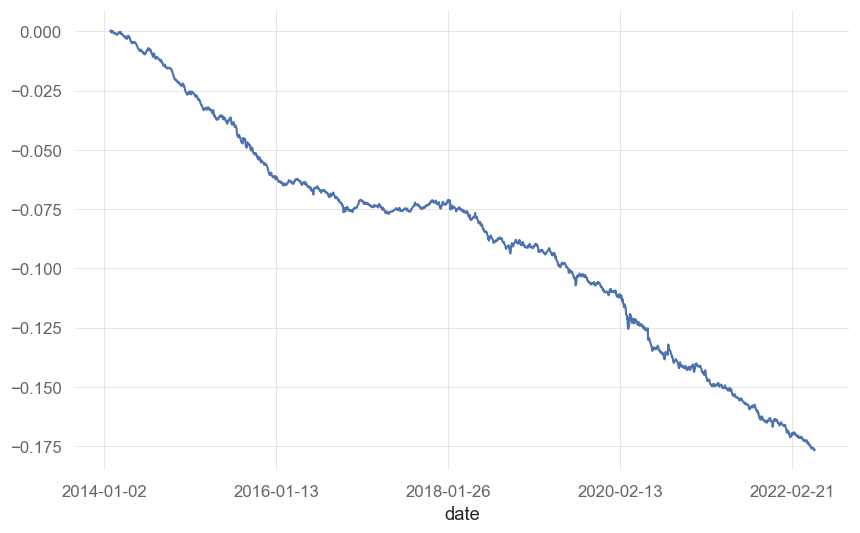

In [85]:
((1+equal_returns).cumprod()-1).plot()

그럼 그렇지.. 1 day shift 차이로 바로 꼴아박는다. 

#### signal weight